## Import needed libraries

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import DatasetFolder, ImageFolder
from torchvision.io import read_image
from torch.autograd import Variable
from torchvision.transforms import ToTensor, Resize, Grayscale, Normalize

import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import glob

import utils

# Loading the dataset and initial data exploration

### Dimension of images

When working with machine learning methods, the dimension of images plays a crucial role. It is important for images to have the same dimensions, as most machine learning models assume consistent-sized image inputs. This requirement arises due to several reasons inherent to the design and functionality of these models.

In [2]:
# Train data
print("Train data:")
utils.check_image_dimensions("screw_data/train/good")

# Test data
print("Test data:")
utils.check_image_dimensions("screw_data/test/good")
utils.check_image_dimensions("screw_data/test/manipulated_front")
utils.check_image_dimensions("screw_data/test/scratch_head")
utils.check_image_dimensions("screw_data/test/scratch_neck")
utils.check_image_dimensions("screw_data/test/thread_side")
utils.check_image_dimensions("screw_data/test/thread_top")

Train data:
All images have the same dimensions: (1024, 1024)
Test data:
All images have the same dimensions: (1024, 1024)
All images have the same dimensions: (1024, 1024)
All images have the same dimensions: (1024, 1024)
All images have the same dimensions: (1024, 1024)
All images have the same dimensions: (1024, 1024)
All images have the same dimensions: (1024, 1024)


All images (train and test) seem to have the same dimensions. We, therefore, do not need to resize them at this point.

### Taking a first look at the images

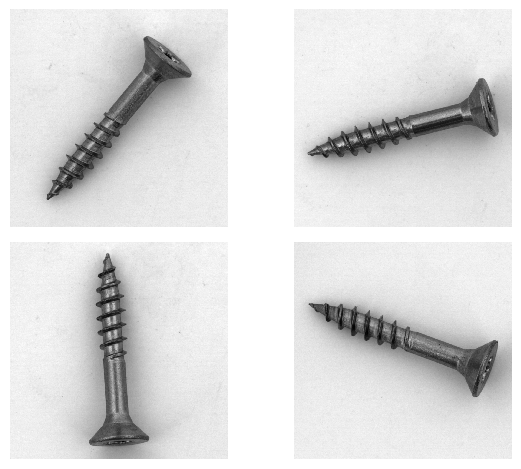

In [3]:
# open 4 train images and display them in a 2x2 grid
train_images = ["screw_data/train/good/000.png",
                "screw_data/train/good/055.png",
                "screw_data/train/good/123.png",
                "screw_data/train/good/291.png"]

utils.display_image_grid(train_images)

The train images predominantly feature a specific model of a screw, with slight variations in screw orientation. It appears that the dataset contains unique images, rather than duplicates or rotated versions of a single image. This uniqueness of images can be advantageous for data augmentation techniques.

Let's now look at some broken examples contained in the testset.

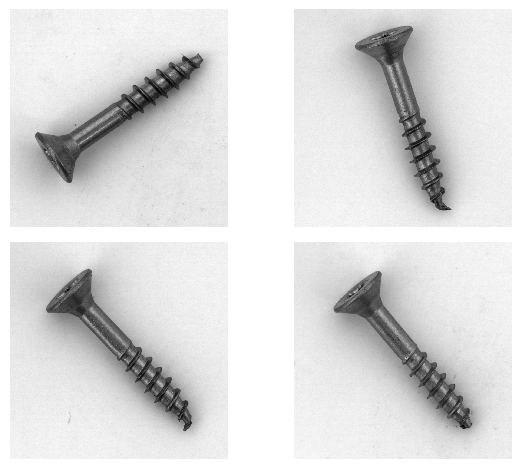

In [4]:
# get 4 random images form the manipulated front directory and display them in a 2x2 grid
#omitted for readability
# manipulated_front_image = glob.glob("screw_data/test/manipulated_front/*.png")
# manipulated_front_image = np.random.choice(manipulated_front_image, 4)
# print(manipulated_front_image)

manipulated_front_image = ['screw_data/test/manipulated_front/021.png',
 'screw_data/test/manipulated_front/005.png',
 'screw_data/test/manipulated_front/013.png',
 'screw_data/test/manipulated_front/001.png']

utils.display_image_grid(manipulated_front_image)

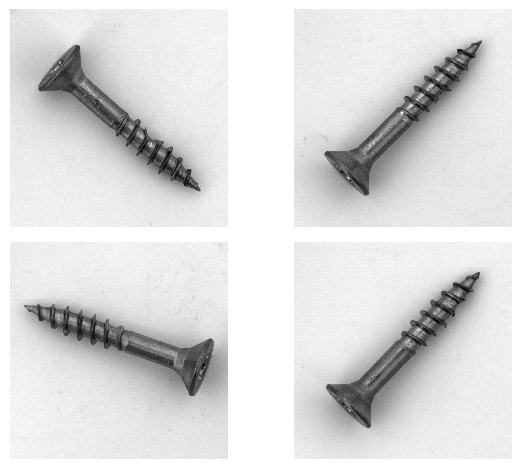

In [5]:
# get 4 random images form the thread side directory and display them in a 2x2 grid
#omitted for readability
#thread_side = glob.glob("screw_data/test/thread_side/*.png")
#thread_side = np.random.choice(thread_side, 4)
#print(thread_side)

thread_side = ['screw_data/test/thread_side/005.png',
 'screw_data/test/thread_side/009.png',
 'screw_data/test/thread_side/015.png',
 'screw_data/test/thread_side/004.png']

utils.display_image_grid(thread_side)

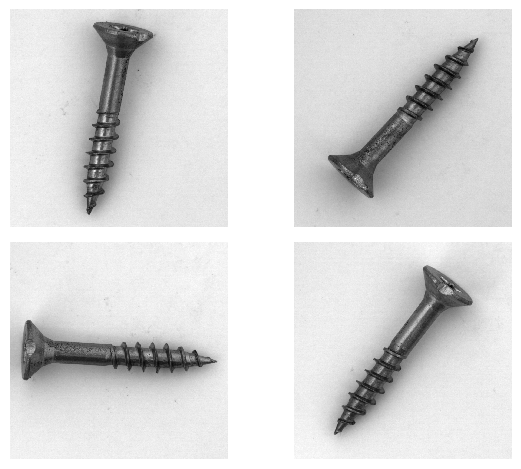

In [6]:
# get 4 random images form the scrath_head directory and display them in a 2x2 grid
# omitted for readability
#scratch_head_images = glob.glob("screw_data/test/scratch_head/*.png")
#scratch_head_images = np.random.choice(scratch_head_images, 4)
#print(scratch_head_images)

scratch_head_images = ['screw_data/test/scratch_head/003.png',
 'screw_data/test/scratch_head/019.png',
 'screw_data/test/scratch_head/007.png',
 'screw_data/test/scratch_head/004.png']

utils.display_image_grid(scratch_head_images)

Upon careful examination, it is apparent that the test images bear a strong resemblance to the train images, primarily owing to the presence of a consistent background. This similarity suggests that the visual characteristics and potential challenges encountered during the analysis of the train images are likely to be encountered in the test images as well.

Notably, when considering the screw objects depicted in the test images, it is evident that the errors present on the screws are generally minor. However, it is important to highlight that the category "manipulated front" displays more severe and easily detectable faults compared to other categories.

Furthermore, as all the images in the dataset are already grayscale, there seems to be no immediate need for preprocessing steps. However, data augmentation techniques can be applied after establishing a performance baseline to enhance the dataset's diversity and address potential challenges.

In [115]:
transform = transforms.Compose([
    Resize((128, 128)),  # resize images
    Grayscale(),  # convert to grayscale
    ToTensor(),  # convert to tensor
])

# load all images in the 'good' directory, assuming they're all good
train_data = ImageFolder(root='screw_data/train', transform=transform)

# create a DataLoader to handle batching of images
train_data_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Performance basline

In [5]:
# We will start with a simple convolutional autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.Sigmoid()  # to ensure the output is between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    


In [8]:
model = Autoencoder()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train(model, dataloader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for images, _ in dataloader:  # we don't need the labels, so we ignore them
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.MSELoss()(outputs, images)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


In [10]:
class ImageFolder(DatasetFolder):
    def __init__(self, root, transform=None, target_transform=None):
        super(ImageFolder, self).__init__(root, loader=read_image, extensions=("jpg", "jpeg", "png", "bmp"), transform=transform, target_transform=target_transform)

In [11]:
transform = transforms.Compose([
    Resize((1024, 1024)),  # resize images
    Grayscale(),  # convert to grayscale
    ToTensor(),  # convert to tensor
    Normalize((0.5,), (0.5,)),  # normalize images
])

# load all images in the 'good' directory, assuming they're all good
dataset = ImageFolder(root='screw_data/train', transform=transform)

# create a DataLoader to handle batching of images
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# train the model
train(model, dataloader, num_epochs=100)


Epoch 1/100
Epoch 1/100, Loss: 0.03070284053683281
Epoch 2/100
Epoch 2/100, Loss: 0.01834414154291153
Epoch 3/100
Epoch 3/100, Loss: 0.017047232016921043
Epoch 4/100
Epoch 4/100, Loss: 0.015965694561600685
Epoch 5/100
Epoch 5/100, Loss: 0.016484595835208893
Epoch 6/100
Epoch 6/100, Loss: 0.014997964724898338
Epoch 7/100
Epoch 7/100, Loss: 0.013713010586798191
Epoch 8/100
Epoch 8/100, Loss: 0.013758305460214615
Epoch 9/100
Epoch 9/100, Loss: 0.014727704226970673
Epoch 10/100
Epoch 10/100, Loss: 0.012799374759197235
Epoch 11/100
Epoch 11/100, Loss: 0.013699826784431934
Epoch 12/100
Epoch 12/100, Loss: 0.012783030979335308
Epoch 13/100
Epoch 13/100, Loss: 0.013447781093418598
Epoch 14/100
Epoch 14/100, Loss: 0.012591329403221607
Epoch 15/100
Epoch 15/100, Loss: 0.01208664570003748
Epoch 16/100
Epoch 16/100, Loss: 0.01179247535765171
Epoch 17/100
Epoch 17/100, Loss: 0.012942886911332607
Epoch 18/100
Epoch 18/100, Loss: 0.01186721958220005
Epoch 19/100
Epoch 19/100, Loss: 0.0129075367003679

In [20]:
# save the model
torch.save(model.state_dict(), 'autoencoder.pth')

In [49]:
test_dataset = ImageFolder(root='screw_data/test', transform=transform)
class_names = test_dataset.classes
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(class_names)


['good', 'manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top']


In [30]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    total_images = 0
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            loss = nn.MSELoss()(outputs, images)
            total_loss += loss.item() * images.size(0)
            total_images += images.size(0)
    return total_loss / total_images


In [43]:
def evaluate(model, dataloader):
    model.eval()
    total_loss_good = 0
    total_loss_bad = 0
    count_good = 0
    count_bad = 0
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            
            # If the label is 0, it's a "good" image
            if labels[0] == 0:
                total_loss_good += loss.item()
                count_good += 1
            else:
                total_loss_bad += loss.item()
                count_bad += 1

    avg_loss_good = total_loss_good / count_good
    avg_loss_bad = total_loss_bad / count_bad

    print(f'Average reconstruction error for good images: {avg_loss_good}')
    print(f'Average reconstruction error for bad images: {avg_loss_bad}')

evaluate(model, test_dataloader)


Average reconstruction error for good images: 0.011781685304169247
Average reconstruction error for bad images: 0.009661955708058691


In [45]:
#### comparison bertween classes in test data
model.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
class_encodings = [[] for i in range(6)]
with torch.no_grad():
    for data in test_loader:
        img, label = data
        img = Variable(img).to(device)
        encoding = model.encoder(img)
        class_encodings[label.item()].append(encoding.cpu().numpy().ravel())

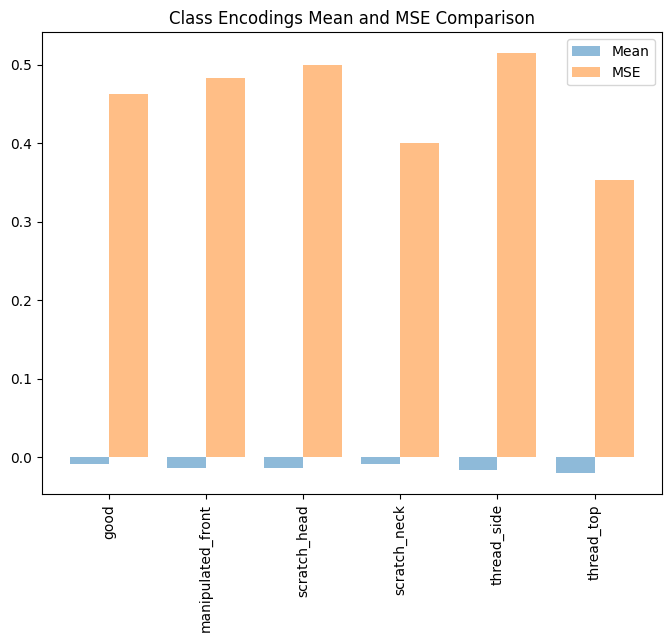

In [50]:
class_means = []
class_mses = []
for i in range(6):
    class_means.append(np.mean(class_encodings[i]))
    class_mse = np.mean((class_encodings[i] - class_means[i])**2)
    class_mses.append(class_mse)

plt.figure(figsize=(8, 6))
plt.bar(np.arange(6)-0.2, class_means, width=0.4, label='Mean', alpha=0.5)
plt.bar(np.arange(6)+0.2, class_mses, width=0.4, label='MSE', alpha=0.5)
plt.xticks(range(6), class_names, rotation=90)
plt.legend()
plt.title("Class Encodings Mean and MSE Comparison")
plt.show()

## Conv Autoencode

In [2]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # (batch_size, 16, 512, 512)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # (batch_size, 32, 256, 256)
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),  # (batch_size, 64, 1, 1)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # (batch_size, 32, 256, 256)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # (batch_size, 16, 512, 512)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # (batch_size, 1, 1024, 1024)
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [53]:
conv_autoencoder = ConvAutoencoder()
optimizer = optim.Adam(conv_autoencoder.parameters(), lr=1e-3)

In [55]:
transform = transforms.Compose([
    Resize((1024, 1024)),  # resize images
    Grayscale(),  # convert to grayscale
    ToTensor(),  # convert to tensor
    Normalize((0.5,), (0.5,)),  # normalize images
])

# load all images in the 'good' directory, assuming they're all good
dataset = ImageFolder(root='screw_data/train', transform=transform)

# create a DataLoader to handle batching of images
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# train the model
train(conv_autoencoder, dataloader, num_epochs=100)


Epoch 1/100
Epoch 1/100, Loss: 0.024191737174987793
Epoch 2/100
Epoch 2/100, Loss: 0.009920446202158928
Epoch 3/100
Epoch 3/100, Loss: 0.01015322282910347
Epoch 4/100
Epoch 4/100, Loss: 0.010822051204741001
Epoch 5/100
Epoch 5/100, Loss: 0.00991270411759615
Epoch 6/100
Epoch 6/100, Loss: 0.009953778237104416
Epoch 7/100
Epoch 7/100, Loss: 0.010014040395617485
Epoch 8/100
Epoch 8/100, Loss: 0.009626147337257862
Epoch 9/100
Epoch 9/100, Loss: 0.00918140634894371
Epoch 10/100
Epoch 10/100, Loss: 0.010201796889305115
Epoch 11/100
Epoch 11/100, Loss: 0.010294278152287006
Epoch 12/100
Epoch 12/100, Loss: 0.009758472442626953
Epoch 13/100
Epoch 13/100, Loss: 0.00890283938497305
Epoch 14/100
Epoch 14/100, Loss: 0.010069536045193672
Epoch 15/100
Epoch 15/100, Loss: 0.00867554359138012
Epoch 16/100
Epoch 16/100, Loss: 0.01018285471946001
Epoch 17/100
Epoch 17/100, Loss: 0.009429793804883957
Epoch 18/100
Epoch 18/100, Loss: 0.009397085756063461
Epoch 19/100
Epoch 19/100, Loss: 0.00918177422136068

In [58]:
# save the model
torch.save(conv_autoencoder.state_dict(), 'conv_autoencoder.pth')

In [59]:
#### comparison bertween classes in test data
conv_autoencoder.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
class_encodings = [[] for i in range(6)]
with torch.no_grad():
    for data in test_loader:
        img, label = data
        img = Variable(img).to(device)
        encoding = conv_autoencoder.encoder(img)
        class_encodings[label.item()].append(encoding.cpu().numpy().ravel())

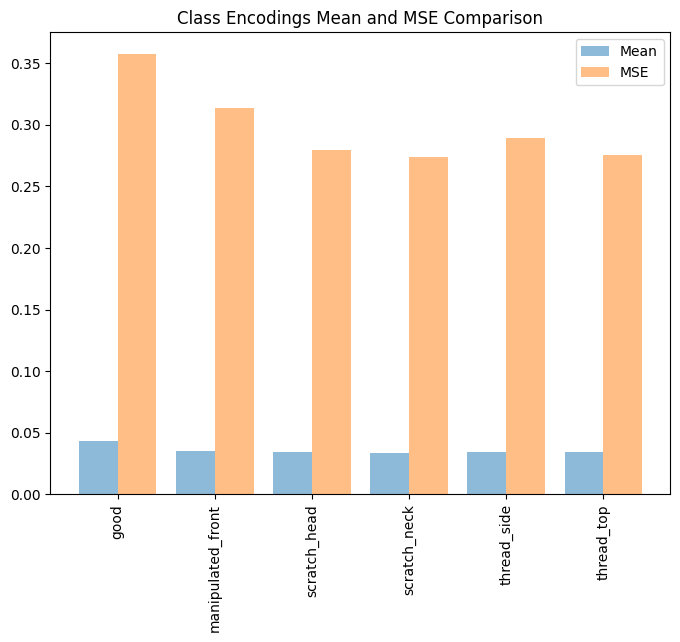

In [60]:
class_means = []
class_mses = []
for i in range(6):
    class_means.append(np.mean(class_encodings[i]))
    class_mse = np.mean((class_encodings[i] - class_means[i])**2)
    class_mses.append(class_mse)

plt.figure(figsize=(8, 6))
plt.bar(np.arange(6)-0.2, class_means, width=0.4, label='Mean', alpha=0.5)
plt.bar(np.arange(6)+0.2, class_mses, width=0.4, label='MSE', alpha=0.5)
plt.xticks(range(6), class_names, rotation=90)
plt.legend()
plt.title("Class Encodings Mean and MSE Comparison")
plt.show()

In [61]:
def calculate_threshold(model, dataloader):
    model.eval()
    losses = []
    criterion = nn.MSELoss()

    with torch.no_grad():
        for images, _ in dataloader:  # we don't need the labels
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            losses.append(loss.item())

    mean = np.mean(losses)
    std = np.std(losses)
    threshold = mean + 2 * std

    return threshold

# Use the training dataloader, as we want to compute the threshold based on the "good" images
threshold = calculate_threshold(conv_autoencoder, dataloader)
print(f'Threshold: {threshold}')


## 2nd convolutional Autoencoder

In [66]:
transform = transforms.Compose([
    Resize((128, 128)),  # resize images
    Grayscale(),  # convert to grayscale
    ToTensor(),  # convert to tensor
])

# load all images in the 'good' directory, assuming they're all good
dataset = ImageFolder(root='screw_data/train', transform=transform)

# create a DataLoader to handle batching of images
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# train the model
train(conv_autoencoder, dataloader, num_epochs=100)


Epoch 1/100
Epoch 1/100, Loss: 0.0021896434482187033
Epoch 2/100
Epoch 2/100, Loss: 0.0014299036702141166
Epoch 3/100
Epoch 3/100, Loss: 0.0011381633812561631
Epoch 4/100
Epoch 4/100, Loss: 0.0010352053213864565
Epoch 5/100
Epoch 5/100, Loss: 0.000925844069570303
Epoch 6/100
Epoch 6/100, Loss: 0.0008878929656930268
Epoch 7/100
Epoch 7/100, Loss: 0.0007883412181399763
Epoch 8/100
Epoch 8/100, Loss: 0.0007203655550256371
Epoch 9/100
Epoch 9/100, Loss: 0.0007134814513847232
Epoch 10/100
Epoch 10/100, Loss: 0.0006257044151425362
Epoch 11/100
Epoch 11/100, Loss: 0.0005885237478651106
Epoch 12/100
Epoch 12/100, Loss: 0.0005864357808604836
Epoch 13/100
Epoch 13/100, Loss: 0.0004819943569600582
Epoch 14/100
Epoch 14/100, Loss: 0.0004936411278322339
Epoch 15/100
Epoch 15/100, Loss: 0.00045252437121234834
Epoch 16/100
Epoch 16/100, Loss: 0.00045742496149614453
Epoch 17/100
Epoch 17/100, Loss: 0.0004185378202237189
Epoch 18/100
Epoch 18/100, Loss: 0.0004532277525868267
Epoch 19/100
Epoch 19/100, 

In [69]:
test_dataset = ImageFolder(root='screw_data/test', transform=transform)
class_names = test_dataset.classes
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(class_names)

['good', 'manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top']


In [70]:
#### comparison bertween classes in test data
conv_autoencoder.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
class_encodings = [[] for i in range(6)]
with torch.no_grad():
    for data in test_loader:
        img, label = data
        img = Variable(img).to(device)
        encoding = conv_autoencoder.encoder(img)
        class_encodings[label.item()].append(encoding.cpu().numpy().ravel())

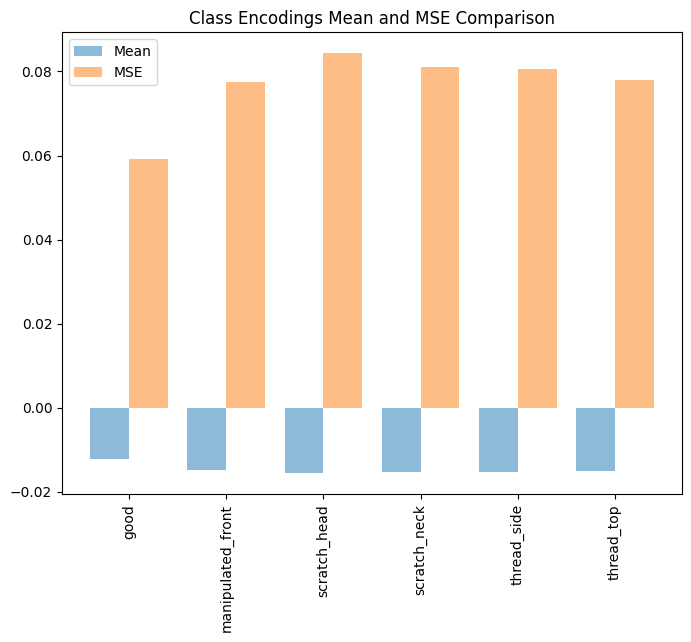

In [71]:
class_means = []
class_mses = []
for i in range(6):
    class_means.append(np.mean(class_encodings[i]))
    class_mse = np.mean((class_encodings[i] - class_means[i])**2)
    class_mses.append(class_mse)

plt.figure(figsize=(8, 6))
plt.bar(np.arange(6)-0.2, class_means, width=0.4, label='Mean', alpha=0.5)
plt.bar(np.arange(6)+0.2, class_mses, width=0.4, label='MSE', alpha=0.5)
plt.xticks(range(6), class_names, rotation=90)
plt.legend()
plt.title("Class Encodings Mean and MSE Comparison")
plt.show()

## 3rd encoder

In [14]:
conv_autoencoder = ConvAutoencoder()
optimizer = optim.Adam(conv_autoencoder.parameters(), lr=1e-3)

In [15]:
# train the model
train(conv_autoencoder, train_data_loader, num_epochs=500)


Epoch 1/500, Loss: 0.05929858610033989
Epoch 2/500, Loss: 0.045290909707546234
Epoch 3/500, Loss: 0.036649808287620544
Epoch 4/500, Loss: 0.02855246514081955
Epoch 5/500, Loss: 0.019801853224635124
Epoch 6/500, Loss: 0.013299955055117607
Epoch 7/500, Loss: 0.011450579389929771
Epoch 8/500, Loss: 0.009909290820360184
Epoch 9/500, Loss: 0.007807380054146051
Epoch 10/500, Loss: 0.00676631648093462
Epoch 11/500, Loss: 0.005618160590529442
Epoch 12/500, Loss: 0.005025573540478945
Epoch 13/500, Loss: 0.00420817406848073
Epoch 14/500, Loss: 0.003763386979699135
Epoch 15/500, Loss: 0.0033689832780510187
Epoch 16/500, Loss: 0.0029926765710115433
Epoch 17/500, Loss: 0.0028439138550311327
Epoch 18/500, Loss: 0.002585525158792734
Epoch 19/500, Loss: 0.002382964361459017
Epoch 20/500, Loss: 0.002245464129373431
Epoch 21/500, Loss: 0.002178288996219635
Epoch 22/500, Loss: 0.0021797209046781063
Epoch 23/500, Loss: 0.001985174370929599
Epoch 24/500, Loss: 0.002017304999753833
Epoch 25/500, Loss: 0.001

In [16]:
test_dataset = ImageFolder(root='screw_data/test', transform=transform)
class_names = test_dataset.classes
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(class_names)

['good', 'manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top']


In [21]:
#### comparison bertween classes in test data
conv_autoencoder.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
class_encodings = [[] for i in range(6)]
with torch.no_grad():
    for data in test_loader:
        img, label = data
        img = Variable(img).to(device)
        encoding = conv_autoencoder.encoder(img)
        class_encodings[label.item()].append(encoding.cpu().numpy().ravel())

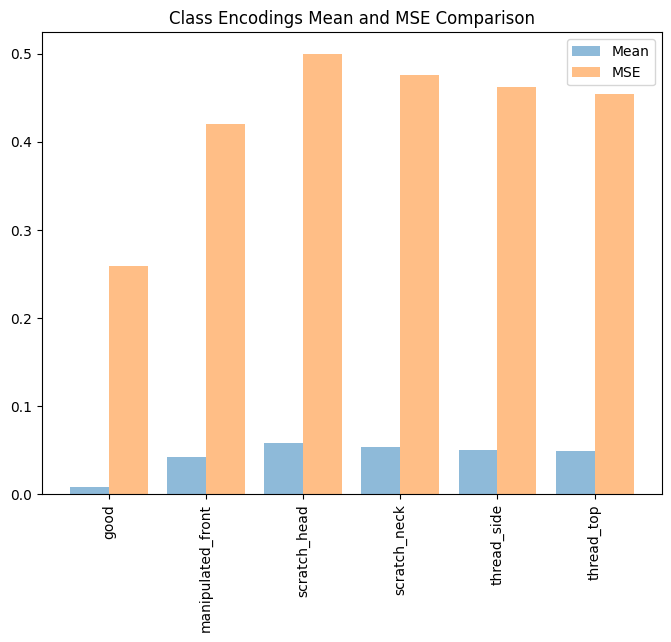

In [22]:
class_means = []
class_mses = []
for i in range(6):
    class_means.append(np.mean(class_encodings[i]))
    class_mse = np.mean((class_encodings[i] - class_means[i])**2)
    class_mses.append(class_mse)

plt.figure(figsize=(8, 6))
plt.bar(np.arange(6)-0.2, class_means, width=0.4, label='Mean', alpha=0.5)
plt.bar(np.arange(6)+0.2, class_mses, width=0.4, label='MSE', alpha=0.5)
plt.xticks(range(6), class_names, rotation=90)
plt.legend()
plt.title("Class Encodings Mean and MSE Comparison")
plt.show()

## Another try

In [122]:
# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [123]:
conv_autoencoder = Autoencoder()
optimizer = optim.Adam(conv_autoencoder.parameters(), lr=1e-3)

In [124]:
# train the model
train(conv_autoencoder, train_data_loader, num_epochs=100)


Epoch 1/100, Loss: 0.4718509614467621
Epoch 2/100, Loss: 0.47102975845336914
Epoch 3/100, Loss: 0.46472904086112976
Epoch 4/100, Loss: 0.4607703685760498
Epoch 5/100, Loss: 0.4463386535644531
Epoch 6/100, Loss: 0.4397749900817871


In [ ]:
test_dataset = ImageFolder(root='screw_data/test', transform=transform)
class_names = test_dataset.classes
print(class_names)

['good', 'manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top']


In [ ]:
#### comparison bertween classes in test data
conv_autoencoder.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
class_encodings = [[] for i in range(6)]
with torch.no_grad():
    for data in test_loader:
        img, label = data
        img = Variable(img).to(device)
        encoding = conv_autoencoder.encoder(img)
        class_encodings[label.item()].append(encoding.cpu().numpy().ravel())

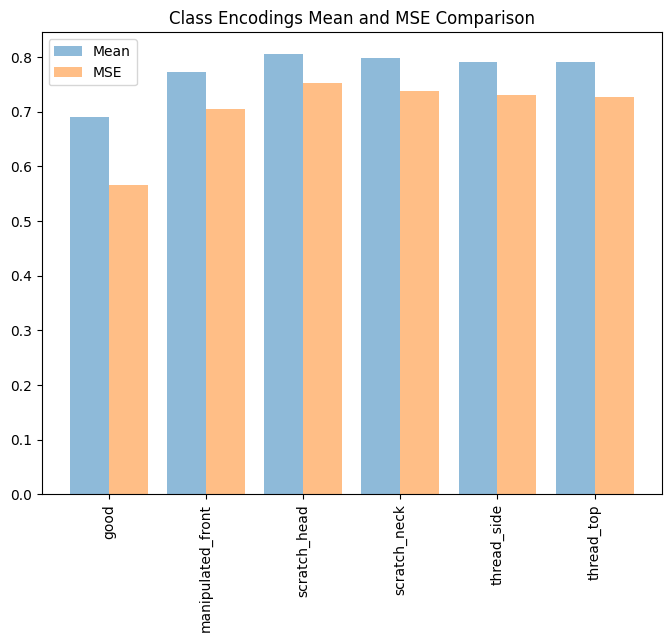

In [ ]:
class_means = []
class_mses = []
for i in range(6):
    class_means.append(np.mean(class_encodings[i]))
    class_mse = np.mean((class_encodings[i] - class_means[i])**2)
    class_mses.append(class_mse)

plt.figure(figsize=(8, 6))
plt.bar(np.arange(6)-0.2, class_means, width=0.4, label='Mean', alpha=0.5)
plt.bar(np.arange(6)+0.2, class_mses, width=0.4, label='MSE', alpha=0.5)
plt.xticks(range(6), class_names, rotation=90)
plt.legend()
plt.title("Class Encodings Mean and MSE Comparison")
plt.show()

In [91]:
def test_image(model, image):
    model.eval()
    image = image.to(device)
    with torch.no_grad():
        output = model(image)
        loss = nn.MSELoss()(output, image)
    return loss.item() > threshold


In [92]:
good_loss = evaluate(conv_autoencoder, test_dataloader)

print(f"Average reconstruction error for 'good' images: {good_loss}")


NameError: name 'evaluate' is not defined